# Realigning every listening subject

There is, for every listen subject, both a stretch, and an offset that need to be considered.

Let's build a dataframe with the information, for each run, of the offset found and the stretch.

Finally, plot the un-stretched and with offset data, compared to the metadata.

## Generate audio ground truth to calculate stretch

In [5]:
# from utils import gen_audio_words_length
import numpy as np

# audio_word_length = gen_audio_words_length()

# # Save this file to csv not to have to load it everytime

# # Save it to numpy file
# np.save('audio_word_length.npy', audio_word_length)


audio_word_length = np.load('audio_word_length.npy')



## Find the offset and stretch

In [23]:
from utils import get_raw
import pandas as pd

df = pd.DataFrame(columns=['subject', 'run', 'offset', 'stretch'])

for subject in range(1,2):
    for run in range(1,4):
        raw, word_triggers, events = get_raw(str(subject), run)
        # Calculate the offset between the first word trigger and the first sample
        offset = word_triggers[0] - raw.first_samp
        # Get the length of the recorded word triggers
        meg_word_length = (word_triggers[-1] - word_triggers[0]) / raw.info['sfreq']
        # Deduct the stretch factor
        stretch = meg_word_length / audio_word_length[run-1]

        # Append the offset and the stretch factor to the dataframe using concat
        df = pd.concat([df, pd.DataFrame({'subject': [subject], 'run': [run], 'offset': [offset], 'stretch': [stretch]})], ignore_index=True)
        # Save the dataframe
        df.to_csv('infos.csv', index=False)

In [24]:
df

,subject,run,offset,stretch
0,1,1,5157,0.999993
1,1,2,4633,0.999981
2,1,3,5127,0.999981


In [ ]:
# Printing the aligned triggers vs the original ones to make sure they are aligned with the stretch applied

# Load the dataframe


In [26]:
raw

<Raw | sub-1_ses-01_task-listen_run-03_meg.fif, 346 x 705000 (705.0 s), ~5.4 MB, data not loaded>

/home/co/workspace_LPP/code/neurospin-petit-prince/dataset_formatting/auditory_realigning/utils.py:80: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/home/co/workspace_LPP/code/neurospin-petit-prince/dataset_formatting/auditory_realigning/utils.py:80: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


(620.0, 630.0)

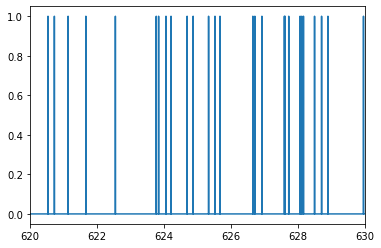

In [29]:
raw, word_triggers, events = get_raw(str(3), run)
raw.pick(['stim', 'misc'])
events = mne.find_events(raw, output='step')
times = np.copy(raw.times)
values = np.zeros_like(times)
values[events[:, 0]-raw.first_samp] = 1
# plt.plot(times, values)
# plt.xlim(0, 100)

wav_fs, wav = wavfile.read('/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download/sourcedata/stimuli/audio/ch1-3.wav')
wav, wav_fs, wav_times = resample_signal(wav, wav_fs, raw.info['sfreq'])

wav_triggers = np.clip(wav[:, 1], 0, 1)

plt.plot(times, values)

offset = word_triggers[0] - raw.first_samp
# Get the length of the recorded word triggers
meg_word_length = (word_triggers[-1] - word_triggers[0]) / raw.info['sfreq']
# Deduct the stretch factor
stretch = meg_word_length / audio_word_length[run-1]
plt.plot(offset+wav_times*stretch, wav_triggers)
plt.xlim(18, 20)
# plt.xlim(20, 50)
# plt.xlim(120, 170)
# plt.xlim(200, 270)
# plt.xlim(200, 210)
# plt.xlim(620, 630)

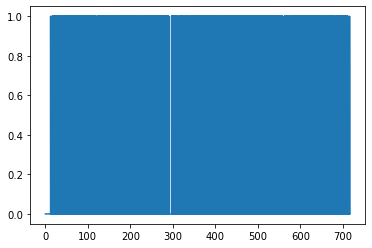

In [44]:
plt.plot(times, values)


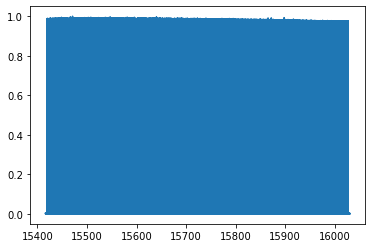

In [34]:
plt.plot(offset+wav_times*stretch, wav_triggers)


(200.0, 270.0)

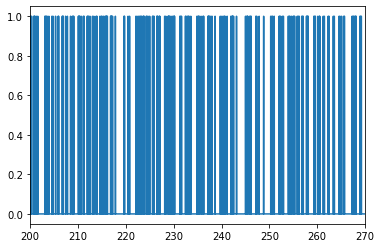

In [33]:
plt.plot(times, values)

offset = word_triggers[0] - raw.first_samp
# Get the length of the recorded word triggers
meg_word_length = (word_triggers[-1] - word_triggers[0]) / raw.info['sfreq']
# Deduct the stretch factor
stretch = meg_word_length / audio_word_length[run-1]
plt.plot(offset+wav_times*stretch, wav_triggers)
# plt.xlim(20, 50)
# plt.xlim(120, 170)
# plt.xlim(200, 270)
# plt.xlim(200, 210)
# plt.xlim(620, 630)

# plt.xlim(20, 50)
# plt.xlim(120, 170)
plt.xlim(200, 270)
# plt.xlim(200, 210)
# plt.xlim(620, 630)

In [25]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.signal import resample
from scipy.signal import correlate
from tqdm import tqdm
from pydantic import BaseModel
import typing as tp
mne.set_log_level(False)

def resample_signal(signal, original_freq, target_freq):
    
    # Calculate the number of samples in the resampled signal
    num_samples_target = int(len(signal) * target_freq / original_freq)
    
    # Resample the signal
    resampled_signal = resample(signal, num_samples_target)
    resampled_signal /= resampled_signal.max(0, keepdims=True)
    
    # Create the time vector for the resampled signal
    resampled_time = np.linspace(0, len(signal) / original_freq, num_samples_target, endpoint=False)
    
    return resampled_signal, target_freq, resampled_time

def gaussian_kernel(size, sigma):
    position = np.arange(size) - size // 2
    kernel_raw = np.exp(-0.5 * (position / sigma) ** 2)
    kernel_normalized = kernel_raw / np.sum(kernel_raw)
    return kernel_normalized
    
def lowpass(data, sfreq, wsize=20):
    window_size = int(.500 * sfreq)
    filter_kernel = gaussian_kernel(window_size, wsize)
    out = np.convolve(data, filter_kernel, mode='same')
    return out / out.max()

def align_series(x, y, stretches, decim=1):
    X, Y = x, y
    if decim:
        x = x[::decim]
        y = y[::decim]

    # pad
    assert len(x) == len(y) # FIXME
    if len(x) < len(y):
        z = np.zeros(len(y)-len(x))
        x = np.r_[z, x]
    elif len(x) > len(y):
        z = np.zeros(len(x)-len(y))
        y = np.r_[z, y]
    n = len(x)

    R = []
    for stretch in tqdm(stretches):
        new_length = int(stretch * n)
        y_hat = resample(y, new_length)
        r = correlate(x, y_hat)
        R.append(r.max())

    best = np.argmax(R)
    strech = stretches[best]

    # offset
    r = correlate(X, Y)
    best = np.argmax(r)
    offsets = np.arange(-len(X) + 1, len(Y))
    offset = offsets[best]
    
    return strech, offset
    

def resample_safe(x, target_length):
    idx = np.linspace(0., len(x)-1, target_length).astype(int)
    return x[idx]
    
class Align(BaseModel):
    stretches: tp.List[float] = np.linspace(.99, 1.02, 500)
    decim: int = 1
    freq: float

    _stretch: float
    _offset: float

    def fit(self, X, Y):
        X = lowpass(X, self.freq)
        Y = lowpass(Y, self.freq)
        self._stretch, self._offset = align_series(Y, X, self.stretches, self.decim)
        return self

    def predict(self, X):
        Y_hat = resample_safe(X, int(self._stretch*len(X)))

        pad = np.zeros(int(np.abs(self._offset)))
        if self._offset>0:
            Y_hat = np.r_[pad, Y_hat]
        elif self._offset<0:
            Y_hat = np.r_[Y_hat, pad]
        return Y_hat

In [26]:
stretch

0.9999934118422136

In [27]:
import matplotlib
matplotlib.use('Qt5Agg')

raw.pick_types(stim=True, misc=True).plot(block=True, start=0, duration=10., precompute='auto')

<MNEBrowseFigure size 1850x1016 with 4 Axes>